# Week 6  - An introduction to machine learning (Part II) - Exercise and Solution

We'll apply some of the material from the previous lectures to recreating the analysis from a [nature machine intelligence](https://www.nature.com/natmachintell/) paper, ["An interpretable mortality prediction model for COVID-19 patients"](https://www.nature.com/articles/s42256-020-0180-7).

## 0. Setup

You will need to install the [xlrd] (https://xlrd.readthedocs.io/en/latest/) package to complete the Exercise.

 To install this packages, launch the "Anaconda Prompt (Anaconda3)" program and run:

`conda install -c anaconda xlrd `

<img src="../img/az_conda_prompt.png">


### Training data

The original training datasets for the paper are linked as [Supplementary data](https://static-content.springer.com/esm/art%3A10.1038%2Fs42256-020-0180-7/MediaObjects/42256_2020_180_MOESM3_ESM.zip). You don't have to download this since we have included the single Excel file we need for this example as `data/time_series_375_preprocess_en.xlsx` in this project. Below we provide code to read the Excel data into a Pandas DataFrame.

In [74]:
import datetime
import pandas as pd

In [75]:
TRAIN_PATH = '../data/time_series_375_preprocess_en.xlsx'
RANDOM_SEED=42

In [107]:
def load_training_data(path):
    """ Load Excel sheet of measurements from patients (timepandas.DataFrame with MultiIndex ['PATIENT_ID', 'RE_DATE'] (the unique patient identifier and patient sample date, corresponding to columns [0,1] respectively of the loaded worksheet), then retain the last set of measurements made per patient, drop 'Admission time', 'Discharge time', 'gender' and 'age' features, and replace NaNs with -1. 
    """

    # Specify explicitly what columns we want to load and what their data types are expected to be.
    DTYPES = {
        'PATIENT_ID': int,
        'RE_DATE': str,
        'age': int,
        'gender': int,
        'Admission time': str,
        'Discharge time': str,
        'outcome': float,
        'Hypersensitive cardiac troponinI': float,
        'hemoglobin': float,
        'Serum chloride': float,
        'Prothrombin time': float,
        'procalcitonin': float,
        'eosinophils(%)': float,
        'Interleukin 2 receptor': float,
        'Alkaline phosphatase': float,
        'albumin': float,
        'basophil(%)': float,
        'Interleukin 10': float,
        'Total bilirubin': float,
        'Platelet count': float,
        'monocytes(%)': float,
        'antithrombin': float,
        'Interleukin 8': float,
        'indirect bilirubin': float,
        'Red blood cell distribution width': float,
        'neutrophils(%)': float,
        'total protein': float,
        'Quantification of Treponema pallidum antibodies': float,
        'Prothrombin activity': float,
        'HBsAg': float,
        'mean corpuscular volume': float,
        'hematocrit': float,
        'White blood cell count': float,
        'Tumor necrosis factorα': float,
        'mean corpuscular hemoglobin concentration': float,
        'fibrinogen': float,
        'Interleukin 1β': float,
        'Urea': float,
        'lymphocyte count': float,
        'PH value': float,
        'Red blood cell count': float,
        'Eosinophil count': float,
        'Corrected calcium': float,
        'Serum potassium': float,
        'glucose': float,
        'neutrophils count': float,
        'Direct bilirubin': float,
        'Mean platelet volume': float,
        'ferritin': float,
        'RBC distribution width SD': float,
        'Thrombin time': float,
        '(%)lymphocyte': float,
        'HCV antibody quantification': float,
        'D-D dimer': float,
        'Total cholesterol': float,
        'aspartate aminotransferase': float,
        'Uric acid': float,
        'HCO3-': float,
        'calcium': float,
        'Amino-terminal brain natriuretic peptide precursor(NT-proBNP)': float,
        'Lactate dehydrogenase': float,
        'platelet large cell ratio ': float,
        'Interleukin 6': float,
        'Fibrin degradation products': float,
        'monocytes count': float,
        'PLT distribution width': float,
        'globulin': float,
        'γ-glutamyl transpeptidase': float,
        'International standard ratio': float,
        'basophil count(#)': float,
        '2019-nCoV nucleic acid detection': float,
        'mean corpuscular hemoglobin': float,
        'Activation of partial thromboplastin time': float,
        'High sensitivity C-reactive protein': float,
        'HIV antibody quantification': float,
        'serum sodium': float,
        'thrombocytocrit': float,
        'ESR': float,
        'glutamic-pyruvic transaminase': float,
        'eGFR': float,
        'creatinine': float
    }

    # Specify which string columns should be interpreted as datetimes.
    DATETIME_COLUMNS = ['RE_DATE', 'Admission time', 'Discharge time']
    
    return (
        pd.read_excel(path, index_col=[0,1], dtype=DTYPES, parse_dates=DATETIME_COLUMNS)
            .sort_index()
            .groupby('PATIENT_ID').last()
            .drop(['Admission time', 'Discharge time'], axis=1)
            .drop(['gender'], axis=1) # removed in later preprocessing step in original paper       
    )

In [108]:
def remove_columns_with_missing_data(df, threshold=0.2):
    """ Remove all columns from DataFrame df where the proportion of missing records is greater than threshold.
    """
    return df.dropna(axis=1, thresh=(1.0-threshold)*len(df))

In [109]:
data = load_training_data(path=TRAIN_PATH)
print(data.shape)
data.head()

(375, 76)


,age,outcome,Hypersensitive cardiac troponinI,hemoglobin,Serum chloride,Prothrombin time,procalcitonin,eosinophils(%),Interleukin 2 receptor,Alkaline phosphatase,...,mean corpuscular hemoglobin,Activation of partial thromboplastin time,High sensitivity C-reactive protein,HIV antibody quantification,serum sodium,thrombocytocrit,ESR,glutamic-pyruvic transaminase,eGFR,creatinine
PATIENT_ID,,,,,,,,,,,,,,,,,,,,,
1,73,0.0,19.9,131.0,100.0,12.4,0.09,1.7,NaN,71.0,...,32.3,38.9,2.6,0.09,142.7,0.16,41.0,30.0,74.7,88.0
2,61,0.0,1.9,149.0,98.1,12.3,0.09,0.1,441.0,45.0,...,32.2,36.0,27.4,NaN,137.4,0.27,40.0,22.0,94.6,74.0
3,70,0.0,NaN,126.0,102.2,13.6,0.06,0.1,591.0,69.0,...,33.3,34.8,3.6,0.10,143.2,0.23,29.0,67.0,84.6,64.0
4,74,0.0,4.8,103.0,103.1,16.3,0.38,2.5,NaN,79.0,...,39.2,NaN,14.5,0.11,144.2,0.27,72.0,26.0,74.2,88.0
5,29,0.0,5.6,130.0,102.2,14.6,0.02,3.0,258.0,84.0,...,30.0,NaN,0.8,0.08,143.6,0.36,11.0,18.0,122.8,54.0


To set things up, as done in the paper, we'll remove all the columns with more than 20% missing data, and separate out our predictors ('X') and response ('y') variables.

In [110]:
data = remove_columns_with_missing_data(data).fillna(-1)
X = data.drop('outcome', axis=1)
y = data.outcome.astype(int)

In [111]:
X.shape

(375, 54)

## Exercises

### 1. Split data into training and test sets.

In [112]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=RANDOM_SEED)

In [113]:
X_train.shape

(262, 54)

### 2. Fit a RandomForestClassifier on the training set.

In [114]:
from sklearn.ensemble import RandomForestClassifier
params = {
    'max_depth': 4, # Maximum depth for the individual decision trees.
    'n_estimators': 150, # Number of trees in the forest.
    'max_features': 'sqrt', # Number of features to consider in each split.
}
model = RandomForestClassifier(**params)
#RandomForestClassifier(max_depth=4, ...)
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=4, max_features='sqrt', n_estimators=150)

### 3. Evaluate the classifier performance by calculating the [confusion matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) and the [F1 score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html) on the test set.

In [116]:
from sklearn.metrics import confusion_matrix, f1_score
y_hat_test = model.predict(X_test)
f1_score(y_test, y_hat_test, labels=[0,1])

0.9803921568627451

In [92]:
X_test

,hemoglobin,Serum chloride,Prothrombin time,procalcitonin,eosinophils(%),Alkaline phosphatase,albumin,basophil(%),Total bilirubin,Platelet count,...,γ-glutamyl transpeptidase,International standard ratio,basophil count(#),mean corpuscular hemoglobin,High sensitivity C-reactive protein,serum sodium,thrombocytocrit,glutamic-pyruvic transaminase,eGFR,creatinine
PATIENT_ID,,,,,,,,,,,,,,,,,,,,,
168,127.0,101.5,14.1,0.03,0.6,70.0,39.2,0.2,28.8,221.0,...,16.0,1.07,0.01,29.5,6.0,140.2,0.23,6.0,55.0,105.0
34,99.0,101.8,13.4,-1.00,6.4,39.0,33.8,0.3,5.8,242.0,...,12.0,1.03,0.01,31.6,20.7,140.4,0.26,10.0,108.0,51.0
16,140.0,107.4,14.8,0.03,0.0,77.0,40.1,0.2,5.7,380.0,...,134.0,1.15,0.01,28.0,46.4,144.2,0.37,47.0,118.7,57.0
317,88.0,96.2,13.4,0.39,0.0,57.0,30.1,0.0,10.2,128.0,...,9.0,1.01,0.00,32.8,185.1,138.1,0.16,9.0,107.0,61.0
58,134.0,105.4,-1.0,-1.00,1.2,50.0,40.1,0.6,7.9,297.0,...,12.0,-1.00,0.03,30.5,0.2,142.0,0.32,16.0,118.9,76.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306,153.0,101.1,14.0,4.93,0.0,150.0,32.9,0.1,10.4,113.0,...,26.0,1.07,0.01,32.8,138.8,142.0,0.12,22.0,20.1,253.0
245,89.0,96.4,28.2,1.36,0.5,125.0,36.2,0.1,505.7,95.0,...,45.0,2.58,0.01,38.0,37.9,132.2,0.12,11.0,46.0,141.0
273,89.0,96.5,15.0,0.37,0.0,52.0,38.9,0.0,5.6,83.0,...,16.0,1.16,0.00,26.6,51.3,133.9,0.10,18.0,27.0,148.0


In [88]:
y_test.value_counts()

0    63
1    50
Name: outcome, dtype: int64

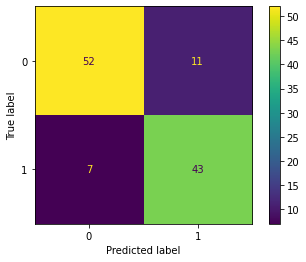

In [89]:
import matplotlib.pyplot as plt
from sklearn import metrics

disp = metrics.ConfusionMatrixDisplay(confusion_matrix(y_test, y_hat_test))
disp.plot()

### 4. Plot the feature importances of the fitted classifier (this is basically the main finding of the Nature paper).

In [93]:
X.columns

Index(['hemoglobin', 'Serum chloride', 'Prothrombin time', 'procalcitonin',
       'eosinophils(%)', 'Alkaline phosphatase', 'albumin', 'basophil(%)',
       'Total bilirubin', 'Platelet count', 'monocytes(%)',
       'indirect bilirubin', 'Red blood cell distribution width ',
       'neutrophils(%)', 'total protein', 'Prothrombin activity',
       'mean corpuscular volume', 'hematocrit', 'White blood cell count',
       'mean corpuscular hemoglobin concentration', 'Urea', 'lymphocyte count',
       'Red blood cell count', 'Eosinophil count', 'Corrected calcium',
       'Serum potassium', 'glucose', 'neutrophils count', 'Direct bilirubin',
       'Mean platelet volume', 'RBC distribution width SD', '(%)lymphocyte',
       'D-D dimer', 'Total cholesterol', 'aspartate aminotransferase',
       'Uric acid', 'HCO3-', 'calcium', 'Lactate dehydrogenase',
       'platelet large cell ratio ', 'monocytes count',
       'PLT distribution width', 'globulin', 'γ-glutamyl transpeptidase',
       'I

<AxesSubplot:ylabel='feature'>

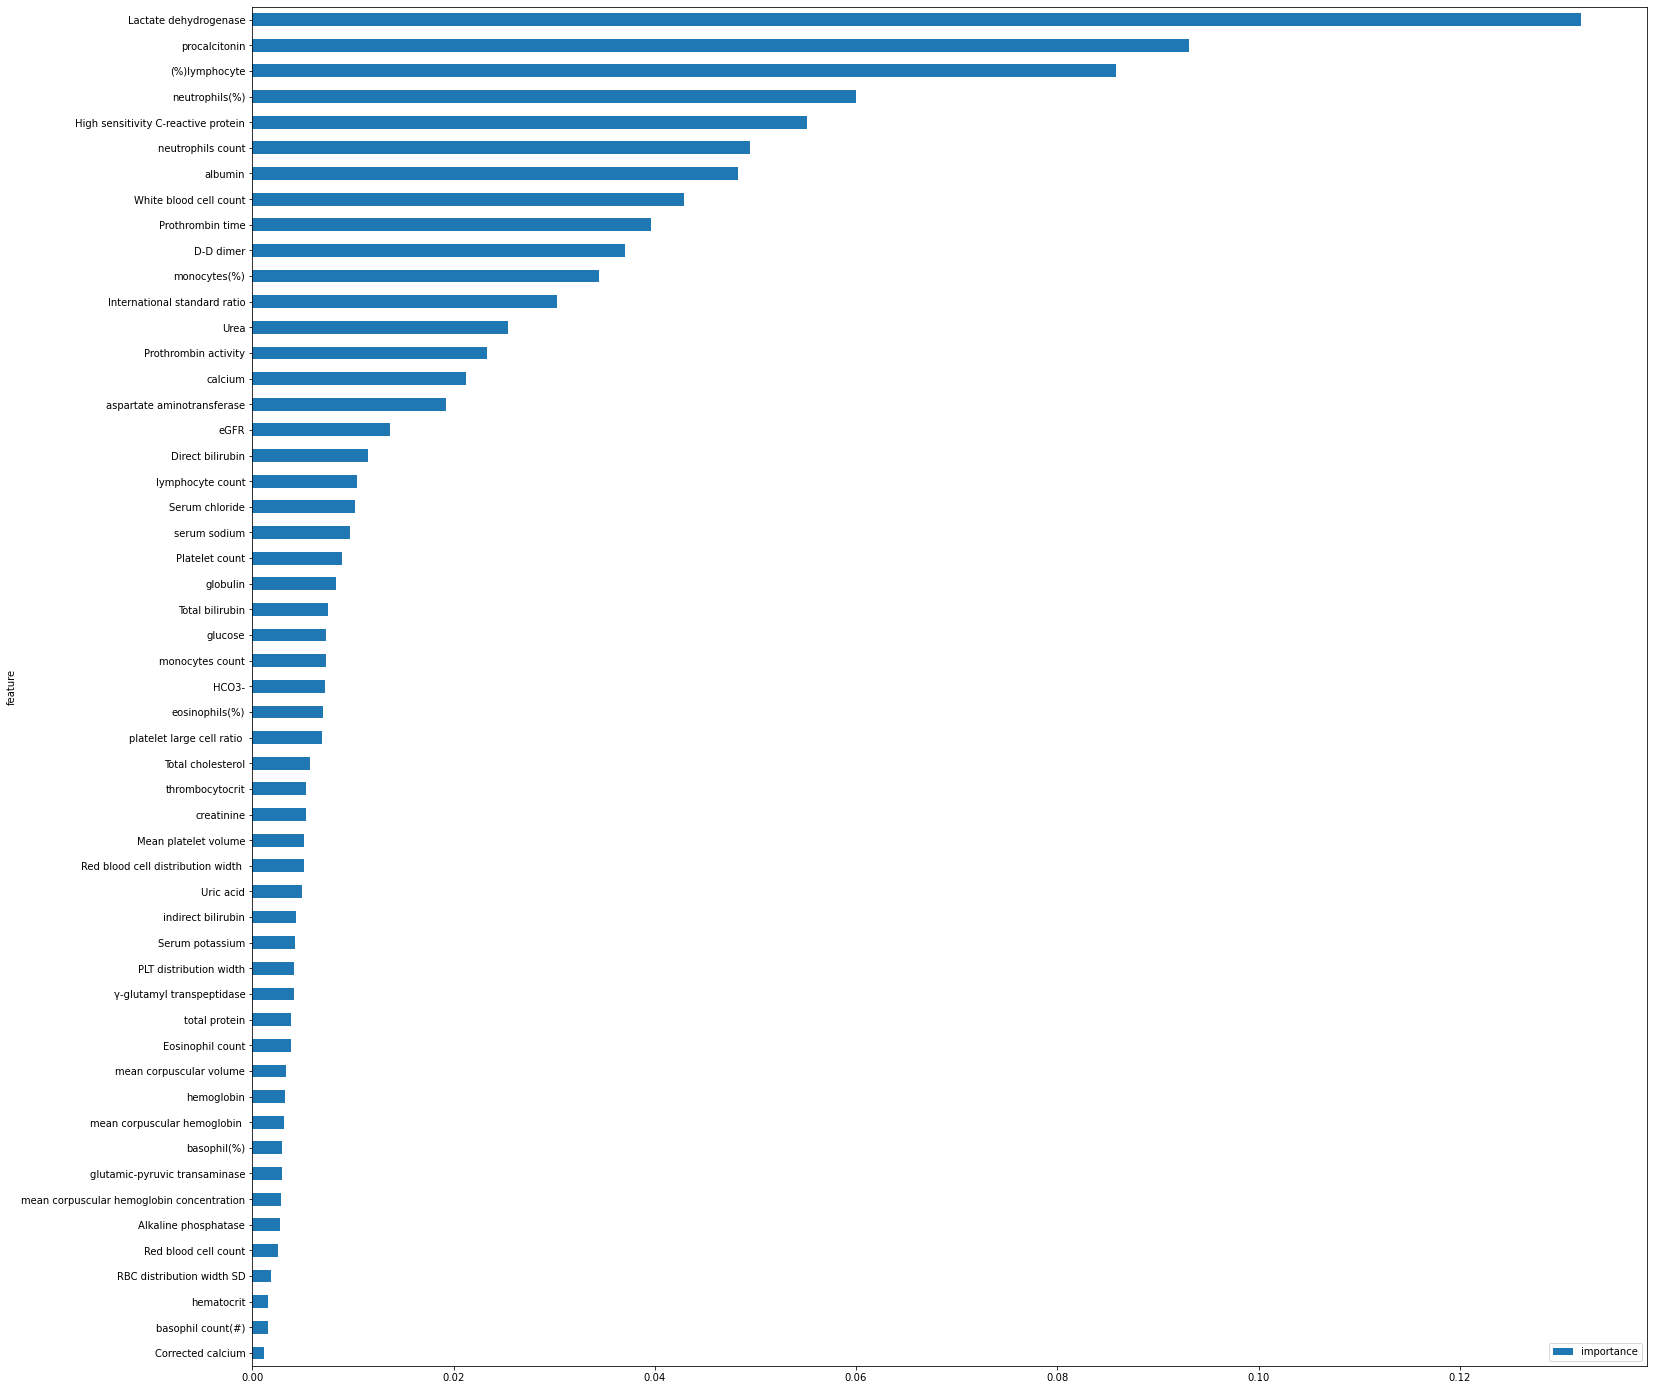

In [90]:
feature_importances = pd.DataFrame()
feature_importances['feature'] = X_train.columns
feature_importances['importance'] = model.feature_importances_
feature_importances.sort_values(by=['importance'], ascending=True, inplace=True)
feature_importances.set_index('feature', inplace=True)

feature_importances.plot(kind='barh', figsize=(25, 25))

In [96]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegresssion()
#RandomForestClassifier(max_depth=4, ...)
model.fit(X_train.loc[:,['Lactate dehydrogenase']], y_train)

NameError: name 'LogisticRegresssion' is not defined

### 5. Try running a different type of classifier and/or see how well you can do on the test set by tuning hyperparameters using cross-validation, grid search or otherwise.

Let's show how to work with XGBoost 

In [51]:
! conda install -c conda-forge -y xgboost

Solving environment: done

# All requested packages already installed.



In [ ]:
param_grid = { 
    'n_estimators': [100, 150, 200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [3,4,5,6,7,8]}

model = GridSearchCV(estimator=xgboost, param_grid=param_grid, cv=cross_validation)
model.fit(X_train, y_train)

## Additional resources

A superb community curated list of resources is at [Awesome machine learning](https://github.com/josephmisiti/awesome-machine-learning).

### Books

If time is of the essence, for a concise but gentle introduction to machine learning that has examples in Python, [The hundred page machine learning book](http://themlbook.com/) 
is tough to beat.

For more Python specifics, Joel Grus [Data science from scratch](https://www.oreilly.com/library/view/data-science-from/9781492041122/) I'm told is good (and has code examples).

For more mathematical background, a personal favourite is Murphy's [Machine learning: a probabilistic perspective](https://www.cs.ubc.ca/~murphyk/MLbook/).

### Online courses

I love the original Stanford courses run by Andrew Ng [Youtube playlist](https://www.youtube.com/view_play_list?p=A89DCFA6ADACE599)(assumes some basic linear algebra and calculus, and doesn't have any programming). These have evolved into Coursera's [Machine Learning](https://www.coursera.org/learn/machine-learning), which is fantastic (and free if you don't need the certification).